### TYK2 Assay Comparisons Across Cell Counts

With the first mini-DMS dataset, we identified candidate partial loss-of-function variants [here](https://github.com/octantbio/dms/blob/master/notebooks/TYK2-Partial-LoF.md) based on whether the change in mutation effect between IFNa and None was both significantly different from zero, and significantly different from the aggregated stop effect. Here, we extend and generalize that analysis to incorporate the second mini-DMS assay dataset. This dataset includes an additional condition for evaluation as a compositional normalized, IFNb, and three separate cell counts. For this analysis, we have the following relevant comparisons:

| Assay | Cell Count | Comparison | Replicate Count |
| :--- | :--- | :--- | :--- |
| #1 | 14 million | IFNa vs None | 3 vs 3 |
| #2 | 7 million | IFNa vs None | 3 vs 3 |
| #2 | 3 million | IFNa vs None | 3 vs 3 |
| #2 | 1 million | IFNa vs None | 3 vs 3 |

We also want to consider the effects of using IFNb as a normalization control, pretending that we have _only_ IFNb and "forgetting" about None. This happens because the way our model shares barcode information means that data points from the None condition can influence the results from comparing IFNa vs IFNb, in particular for barcodes that None shares with IFNa but not IFNb (or vice versa). So, we also have the following comparisons, computed without using None barcode information in any way:

| Assay | Cell Count | Comparison | Replicate Count |
| :--- | :--- | :--- | :--- |
| #2 | 7 million | IFNa vs IFNb | 3 vs 3 |
| #2 | 3 million | IFNa vs IFNb | 3 vs 3 |
| #2 | 1 million | IFNa vs IFNb | 3 vs 3 |

For each of these comparisons, we have a set of summary statistics. In each set, each mutation has an estimated effect size, denoted here as the log2 fold change of IFNa vs None or IFNa vs IFNb, and an associated standard error. The ratio of the effect size to the standard error defins the z-statistic, which is used to compute nominal and Benjamini-Hochberg adjusted p-values. In general, we show error bars as +/- 3 standard errors and define FDR cutoffs at 1%.

In [42]:
library(ggpubr)
library(ggcorrplot)
library(ggbeeswarm)
library(UpSetR)
library(fs)
library(knitr)
library(patchwork)
library(venn)
library(kableExtra)
library(tidyverse)

#### Distributions of Mutation Effects

In general, higher cell densities result in data with higher numbers of successfully quantified barcodes, leading to a decrease in standard error. We also observe a similar effect with fold changes, where lower cell densities have slightly exaggerated effect sizes along with elevated variance.

In [14]:
files <- dir_ls("../sumstats/", glob = "*mil-noifnb-combined*tsv")
names(files) <- gsub("../sumstats/10-|-noifnb-combined.sumstats.tsv","",files)
sumstats <- files %>% map_dfr(read_tsv, .id = "density") %>%
    separate(term, c("condition", "mut_aa"), ":") %>%
    mutate(condition = gsub("condition", "", condition),
           mut_aa = gsub("mut_aa", "", mut_aa)) %>%
    select(density, pos, condition, mut_aa, dispersion, estimate, std.error) %>%
    filter(condition %in% c("ifna", "none"), !is.na(mut_aa)) %>%
    group_by(density, pos, mut_aa) %>%
    pivot_wider(names_from = "condition", values_from = c("estimate", "std.error")) %>%
    mutate(estimate = estimate_ifna - estimate_none,
           std.error = sqrt(std.error_ifna^2 + std.error_none^2),
           statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"),
           density = factor(density, levels = c("1mil","3mil","7mil","14mil")))

files <- dir_ls("../sumstats/", glob = "*mil-nonone-combined*tsv")
names(files) <- gsub("../sumstats/10-|-nonone-combined.sumstats.tsv","",files)
sumstats_ifnb <- files %>% map_dfr(read_tsv, .id = "density") %>%
    separate(term, c("condition", "mut_aa"), ":") %>%
    mutate(condition = gsub("condition", "", condition),
           mut_aa = gsub("mut_aa", "", mut_aa)) %>%
    select(density, pos, condition, mut_aa, dispersion, estimate, std.error) %>%
    filter(condition %in% c("ifna", "ifnb"), !is.na(mut_aa)) %>%
    group_by(density, pos, mut_aa) %>%
    pivot_wider(names_from = "condition", values_from = c("estimate", "std.error")) %>%
    mutate(estimate = estimate_ifna - estimate_ifnb,
           std.error = sqrt(std.error_ifna^2 + std.error_ifnb^2),
           statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"),
           density = factor(density, levels = c("1mil","3mil","7mil","14mil")))

sumstats_all <- bind_rows(sumstats %>% mutate("group" = "Normalized\nto Untreated"),
                          sumstats_ifnb %>% mutate("group" = "Normalized\nto IFNb"))

Rows: 4480 Columns: 10

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): clone, term, version
dbl (7): pos, chunk, estimate, std.error, statistic, p.value, dispersion


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 3010 Columns: 10

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): clone, term, version
dbl (7): pos, chunk, estimate, std.error, statistic, p.value, dispersion


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 3010 Columns: 10

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): clone, term, version
dbl (7): pos, chunk, estimate, std.error, statistic, p.value, dispersion


ℹ Use `spec(

In [15]:
l2fc_plot <- sumstats_all %>%
    ggplot() +
        geom_quasirandom(aes(y = estimate/log(2), x = group),
                         varwidth = TRUE, size = 0.5) +
        theme_pubr(base_size = 20) +
        ylab("Log2 Fold Change") +
        xlab("") +
        facet_wrap(~density, ncol = 1) + 
        coord_flip() +
        scale_color_identity()

se_plot <- sumstats_all %>%
    ggplot() +
        geom_quasirandom(aes(y = std.error/log(2), x = group),
                         varwidth = TRUE, size = 0.5) +
        theme_pubr(base_size = 20) +
        theme(axis.text.y = element_blank()) +
        ylab("Standard Error of the Log2 Fold Change") +
        facet_wrap(~density, ncol = 1) + 
        coord_flip() +
        ylim(c(0,0.75))

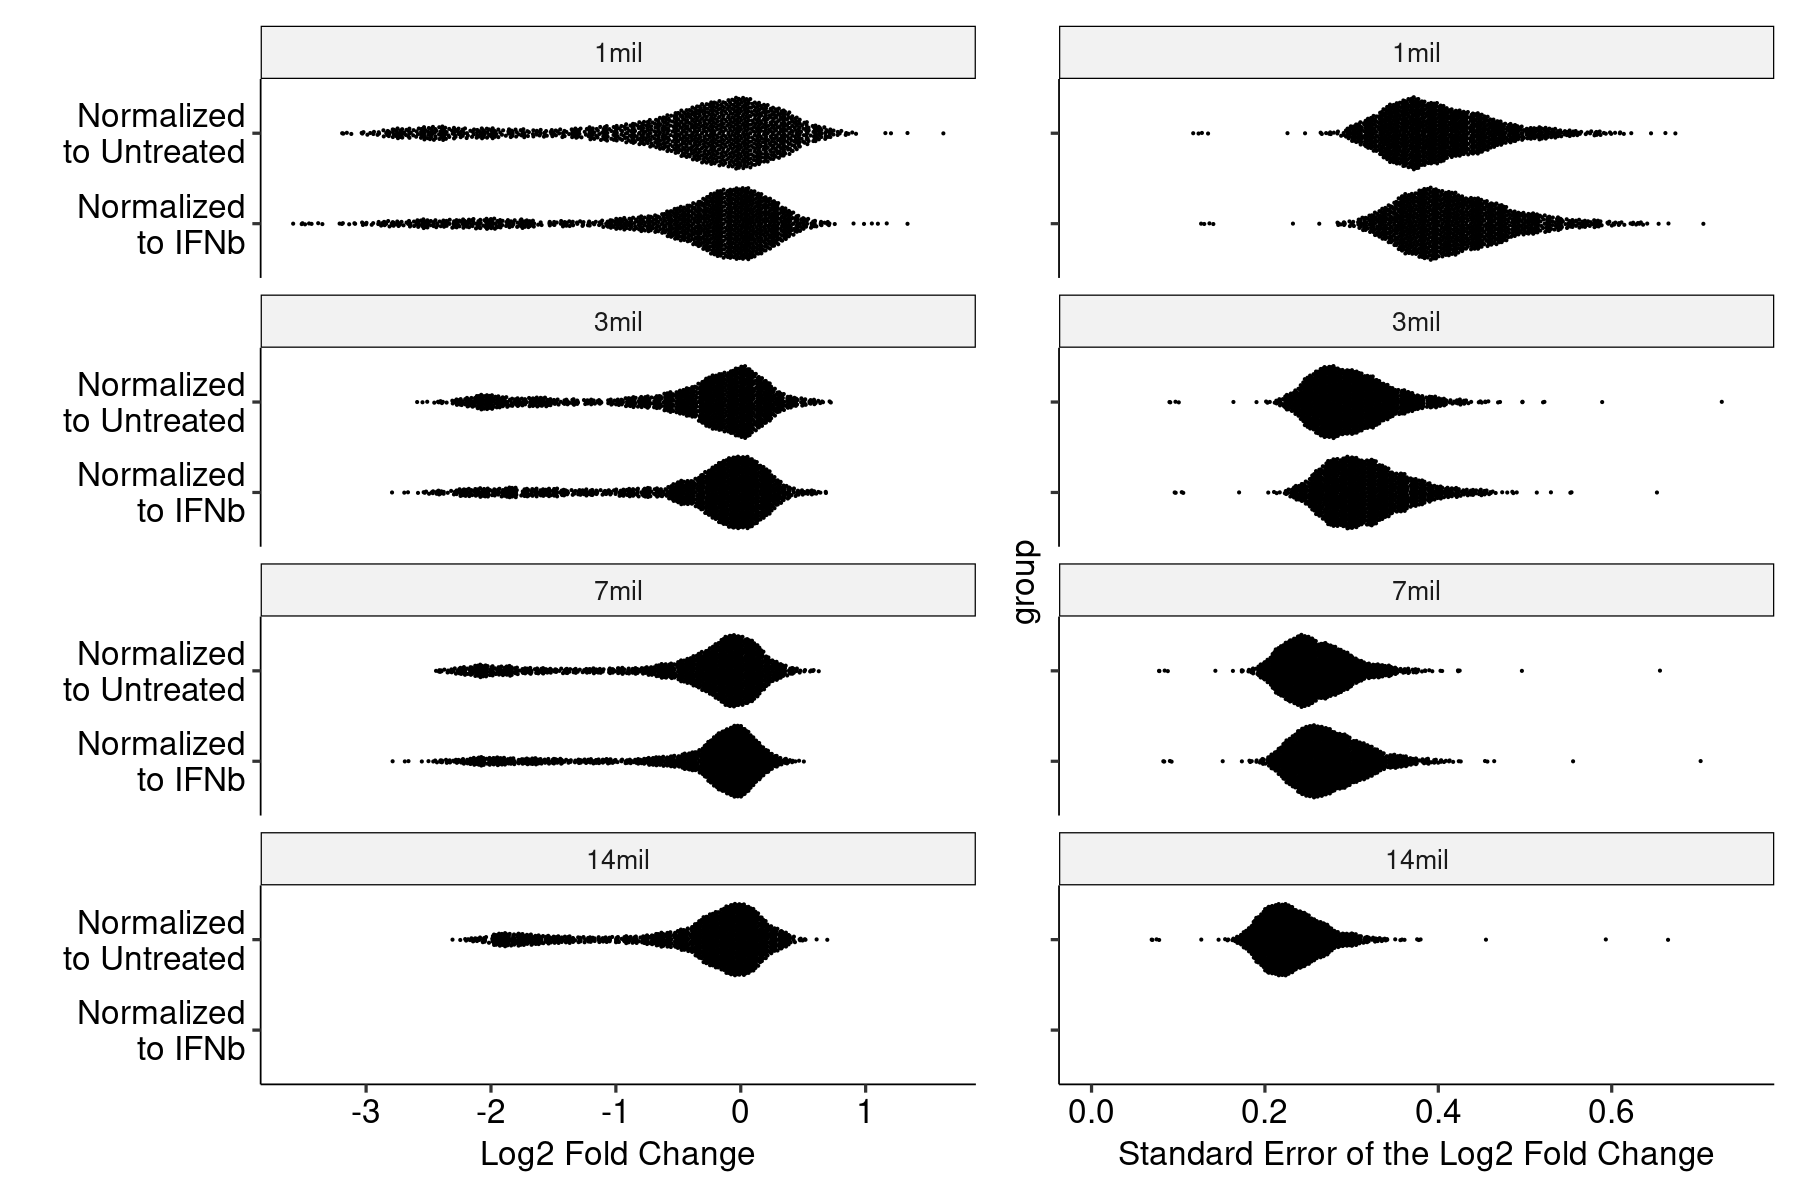

In [16]:
options(repr.plot.width = 15, repr.plot.height = 10, warn = -1)
(l2fc_plot | se_plot)

For each of these comparisons, we can plot the long-form confidence intervals ordered by log2 fold change. While the distributions shown in the two columns below are the same, the left side highlights stop mutations in red, while the right side highlights alanine mutations: 

In [19]:
plot_effect_dist <- function(df, title, AA = "*"){
    
    data <- df %>%
        ungroup() %>%
        arrange(estimate) %>%
        mutate(id = 1:length(estimate),
               estimate = estimate / log(2),
               std.error = std.error / log(2))
    
    thePlot <-  data %>%
        ggplot() +
            geom_pointrange(aes(x = as.factor(id), y = estimate,
                                ymin = estimate - 3*std.error,
                                ymax = estimate + 3*std.error,
                                color = if_else(mut_aa == AA, "red", "black"),
                                size = if_else(mut_aa == AA, 1, 0.5),
                                alpha = if_else(mut_aa == AA, 1, 0.25))) +
            geom_hline(aes(yintercept = estimate + 3*std.error),
                           data = data %>% filter(pos == -1), color = "red") +
            geom_hline(aes(yintercept = estimate - 3*std.error),
                           data = data %>% filter(pos == -1), color = "red") +
            theme_pubr(base_size = 16) +
            theme(axis.text.x = element_blank(),
                  axis.ticks.x = element_blank()) +
            scale_color_identity() +
            scale_alpha_identity() +
            scale_size_identity() +
            geom_hline(yintercept = 0) +
            xlab("Variant") + ylab("Log2 Fold Change") +
            ggtitle(title) +
            coord_cartesian(ylim = c(-3.5, 1.5))

    return(thePlot)
    
}

sumstats_nest <- sumstats_all %>% 
    nest(df = !c(density, group)) %>%
    mutate(group = gsub("\n", " ", group))

interval_plots <- pmap(list(rep(sumstats_nest$df,2),
                            rep(paste0(sumstats_nest$density, " ", gsub("\n"," ",sumstats_nest$group)),2),
                            c(rep("*",length(sumstats_nest$df)), rep("A",length(sumstats_nest$df)))),
                        plot_effect_dist)

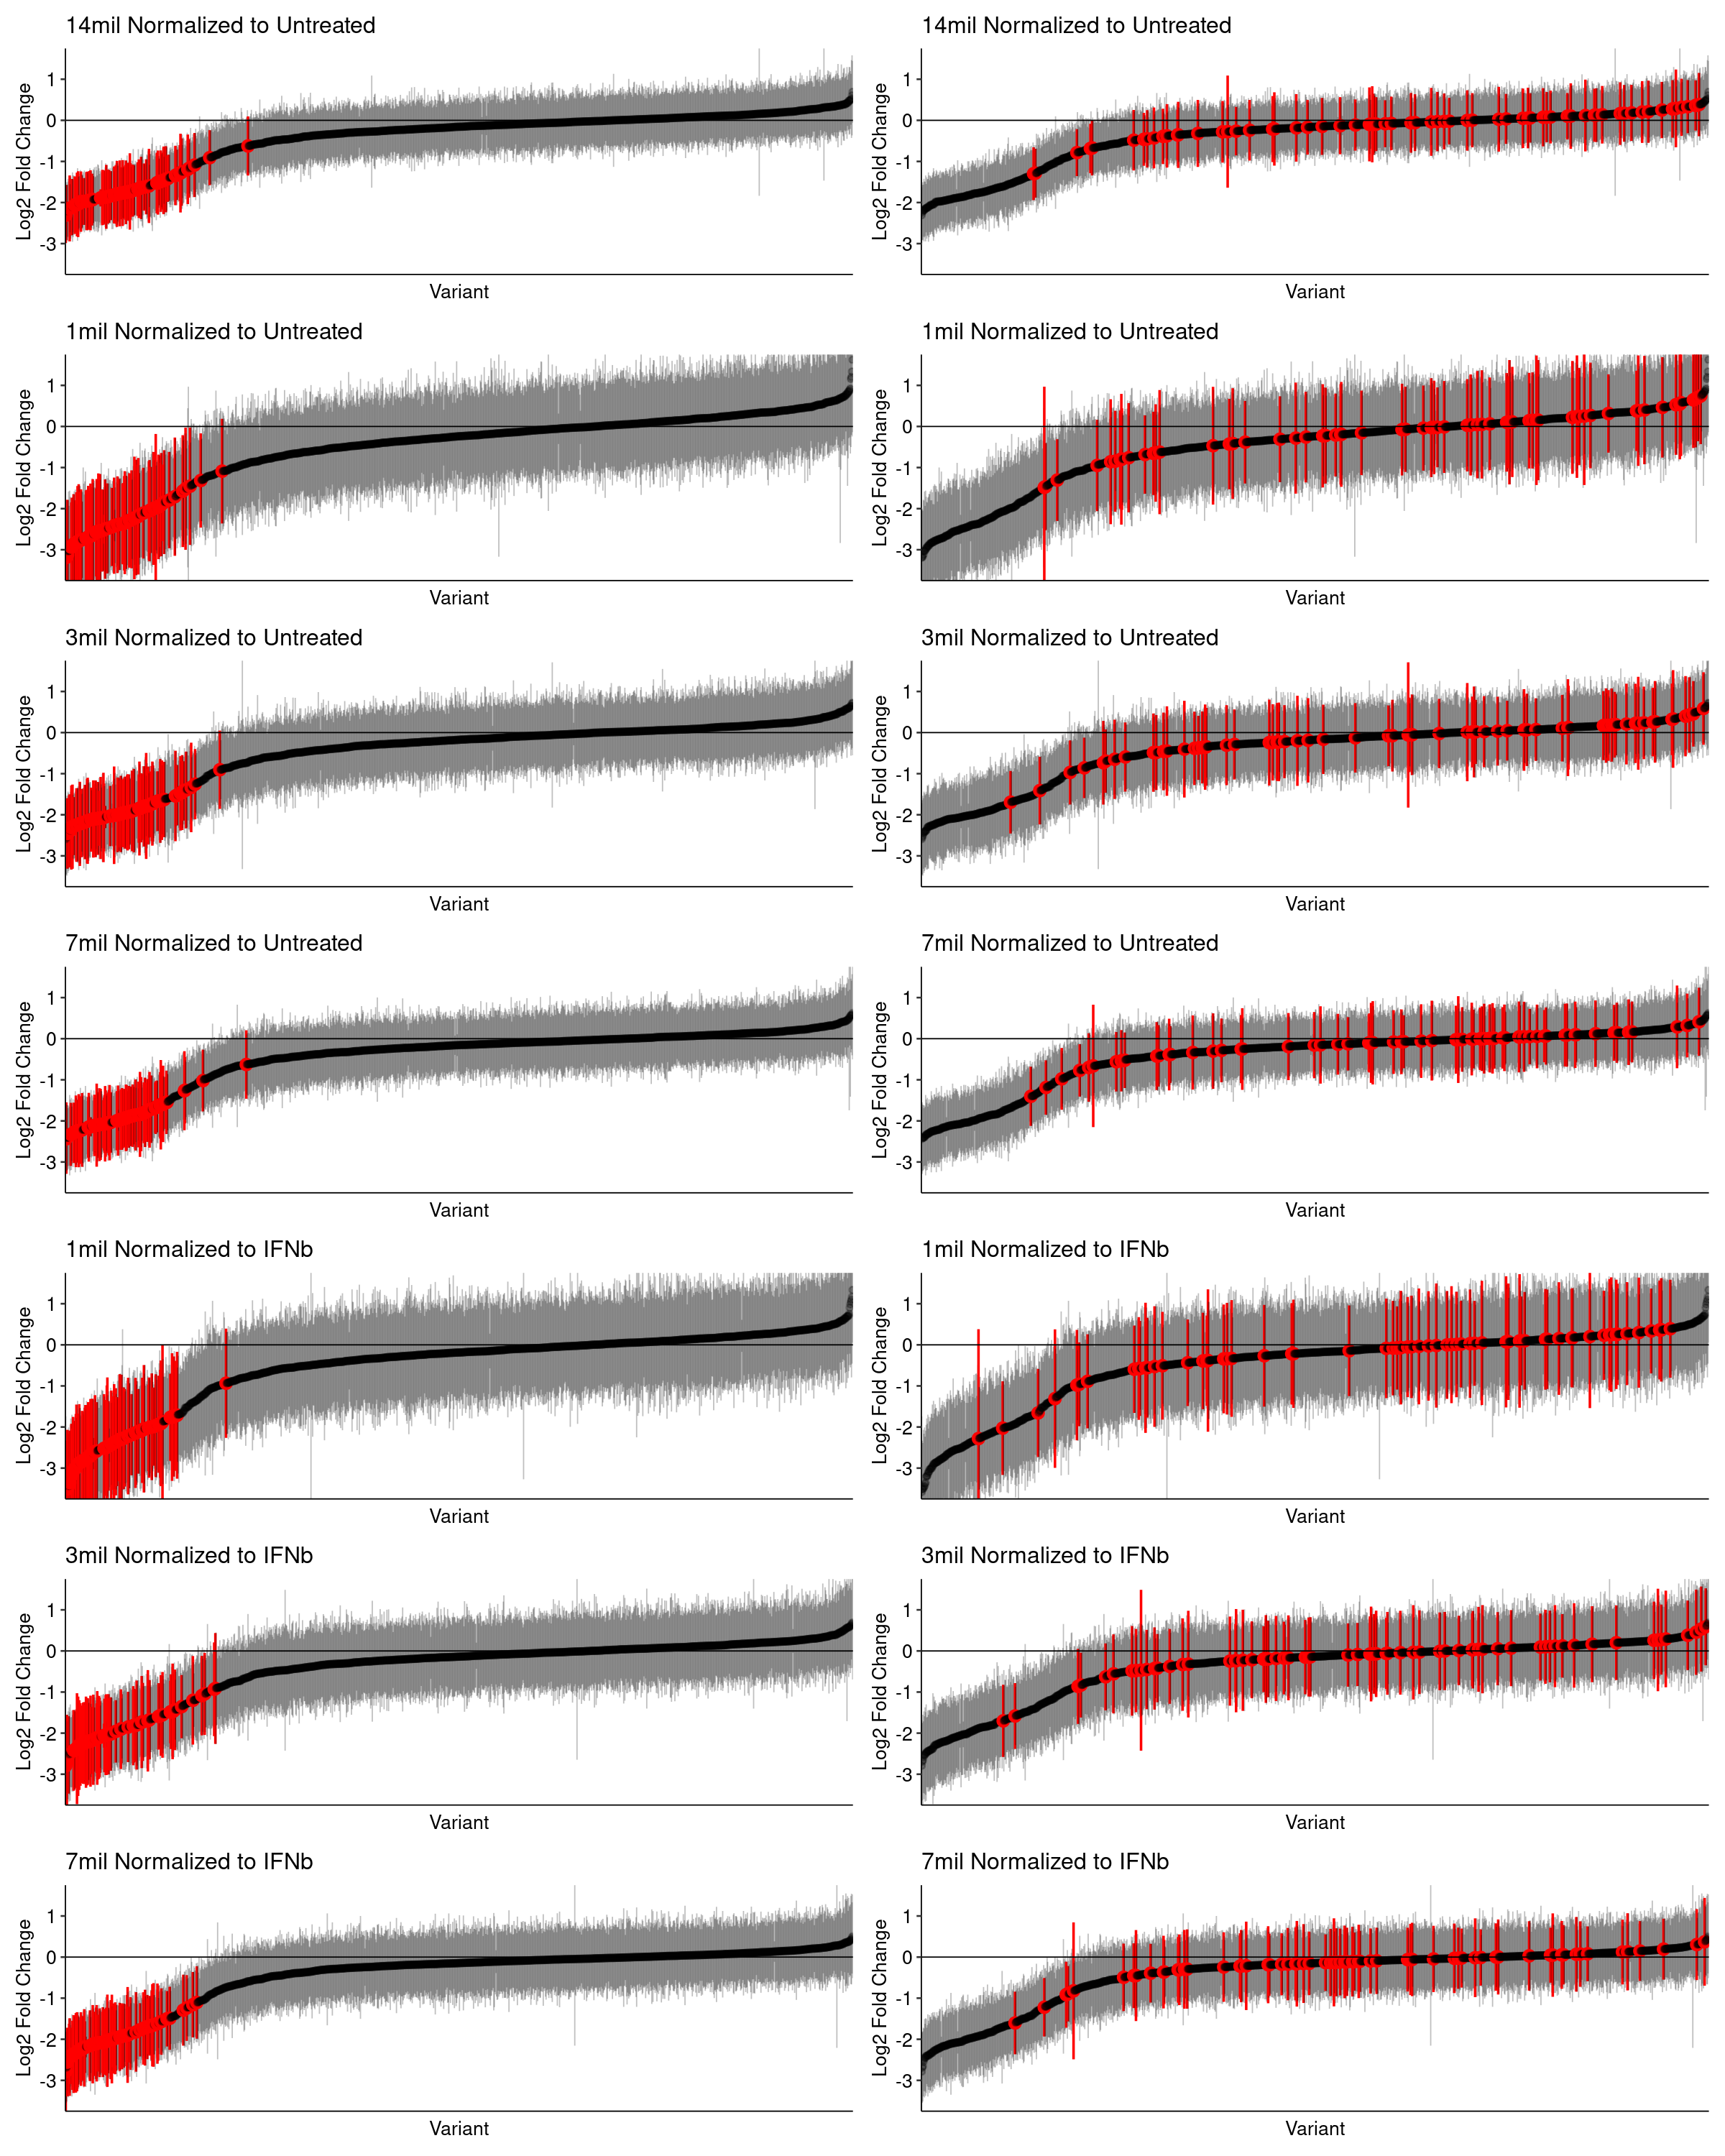

In [22]:
options(repr.plot.width = 20, repr.plot.height = 25)
wrap_plots(interval_plots, ncol = 2, byrow = FALSE)

If we aggregate the stop effects into a single value, we can compute a confidence interval on the global average stop effect. This is _a priori_ reaosnable, since we expect a stop codon to have a similar effect on protein function regardless of where in chunk 10 it is located.

In [25]:
files <- dir_ls("../sumstats/", glob = "*mil-noifnb-stopagg*tsv")
names(files) <- gsub("../sumstats/10-|-noifnb-stopagg.sumstats.tsv","",files)
sumstats <- files %>% map_dfr(read_tsv, .id = "density") %>%
    separate(term, c("condition", "mut_aa"), ":") %>%
    mutate(condition = gsub("condition", "", condition),
           mut_aa = gsub("mut_aa", "", mut_aa)) %>%
    select(density, pos, condition, mut_aa, dispersion, estimate, std.error) %>%
    filter(condition %in% c("ifna", "none"), !is.na(mut_aa)) %>%
    group_by(density, pos, mut_aa) %>%
    pivot_wider(names_from = "condition", values_from = c("estimate", "std.error")) %>%
    mutate(estimate = estimate_ifna - estimate_none,
           std.error = sqrt(std.error_ifna^2 + std.error_none^2),
           statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"),
           density = factor(density, levels = c("1mil","3mil","7mil","14mil")))

files <- dir_ls("../sumstats/", glob = "*mil-nonone-stopagg*tsv")
names(files) <- gsub("../sumstats/10-|-nonone-stopagg.sumstats.tsv","",files)
sumstats_ifnb <- files %>% map_dfr(read_tsv, .id = "density") %>%
    separate(term, c("condition", "mut_aa"), ":") %>%
    mutate(condition = gsub("condition", "", condition),
           mut_aa = gsub("mut_aa", "", mut_aa)) %>%
    select(density, pos, condition, mut_aa, dispersion, estimate, std.error) %>%
    filter(condition %in% c("ifna", "ifnb"), !is.na(mut_aa)) %>%
    group_by(density, pos, mut_aa) %>%
    pivot_wider(names_from = "condition", values_from = c("estimate", "std.error")) %>%
    mutate(estimate = estimate_ifna - estimate_ifnb,
           std.error = sqrt(std.error_ifna^2 + std.error_ifnb^2),
           statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"),
           density = factor(density, levels = c("1mil","3mil","7mil","14mil")))

sumstats_all <- bind_rows(sumstats %>% mutate("group" = "Normalized\nto Untreated"),
                          sumstats_ifnb %>% mutate("group" = "Normalized\nto IFNb"))

sumstats_nest <- sumstats_all %>% 
    nest(df = !c(density, group)) %>%
    mutate(group = gsub("\n", " ", group))

interval_plots <- pmap(list(sumstats_nest$df,
                                   paste0(sumstats_nest$density, " ", gsub("\n"," ",sumstats_nest$group))),
                              plot_effect_dist)

Rows: 4277 Columns: 10

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): clone, term, version
dbl (7): pos, chunk, estimate, std.error, statistic, p.value, dispersion


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 2875 Columns: 10

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): clone, term, version
dbl (7): pos, chunk, estimate, std.error, statistic, p.value, dispersion


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 2875 Columns: 10

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): clone, term, version
dbl (7): pos, chunk, estimate, std.error, statistic, p.value, dispersion


ℹ Use `spec(

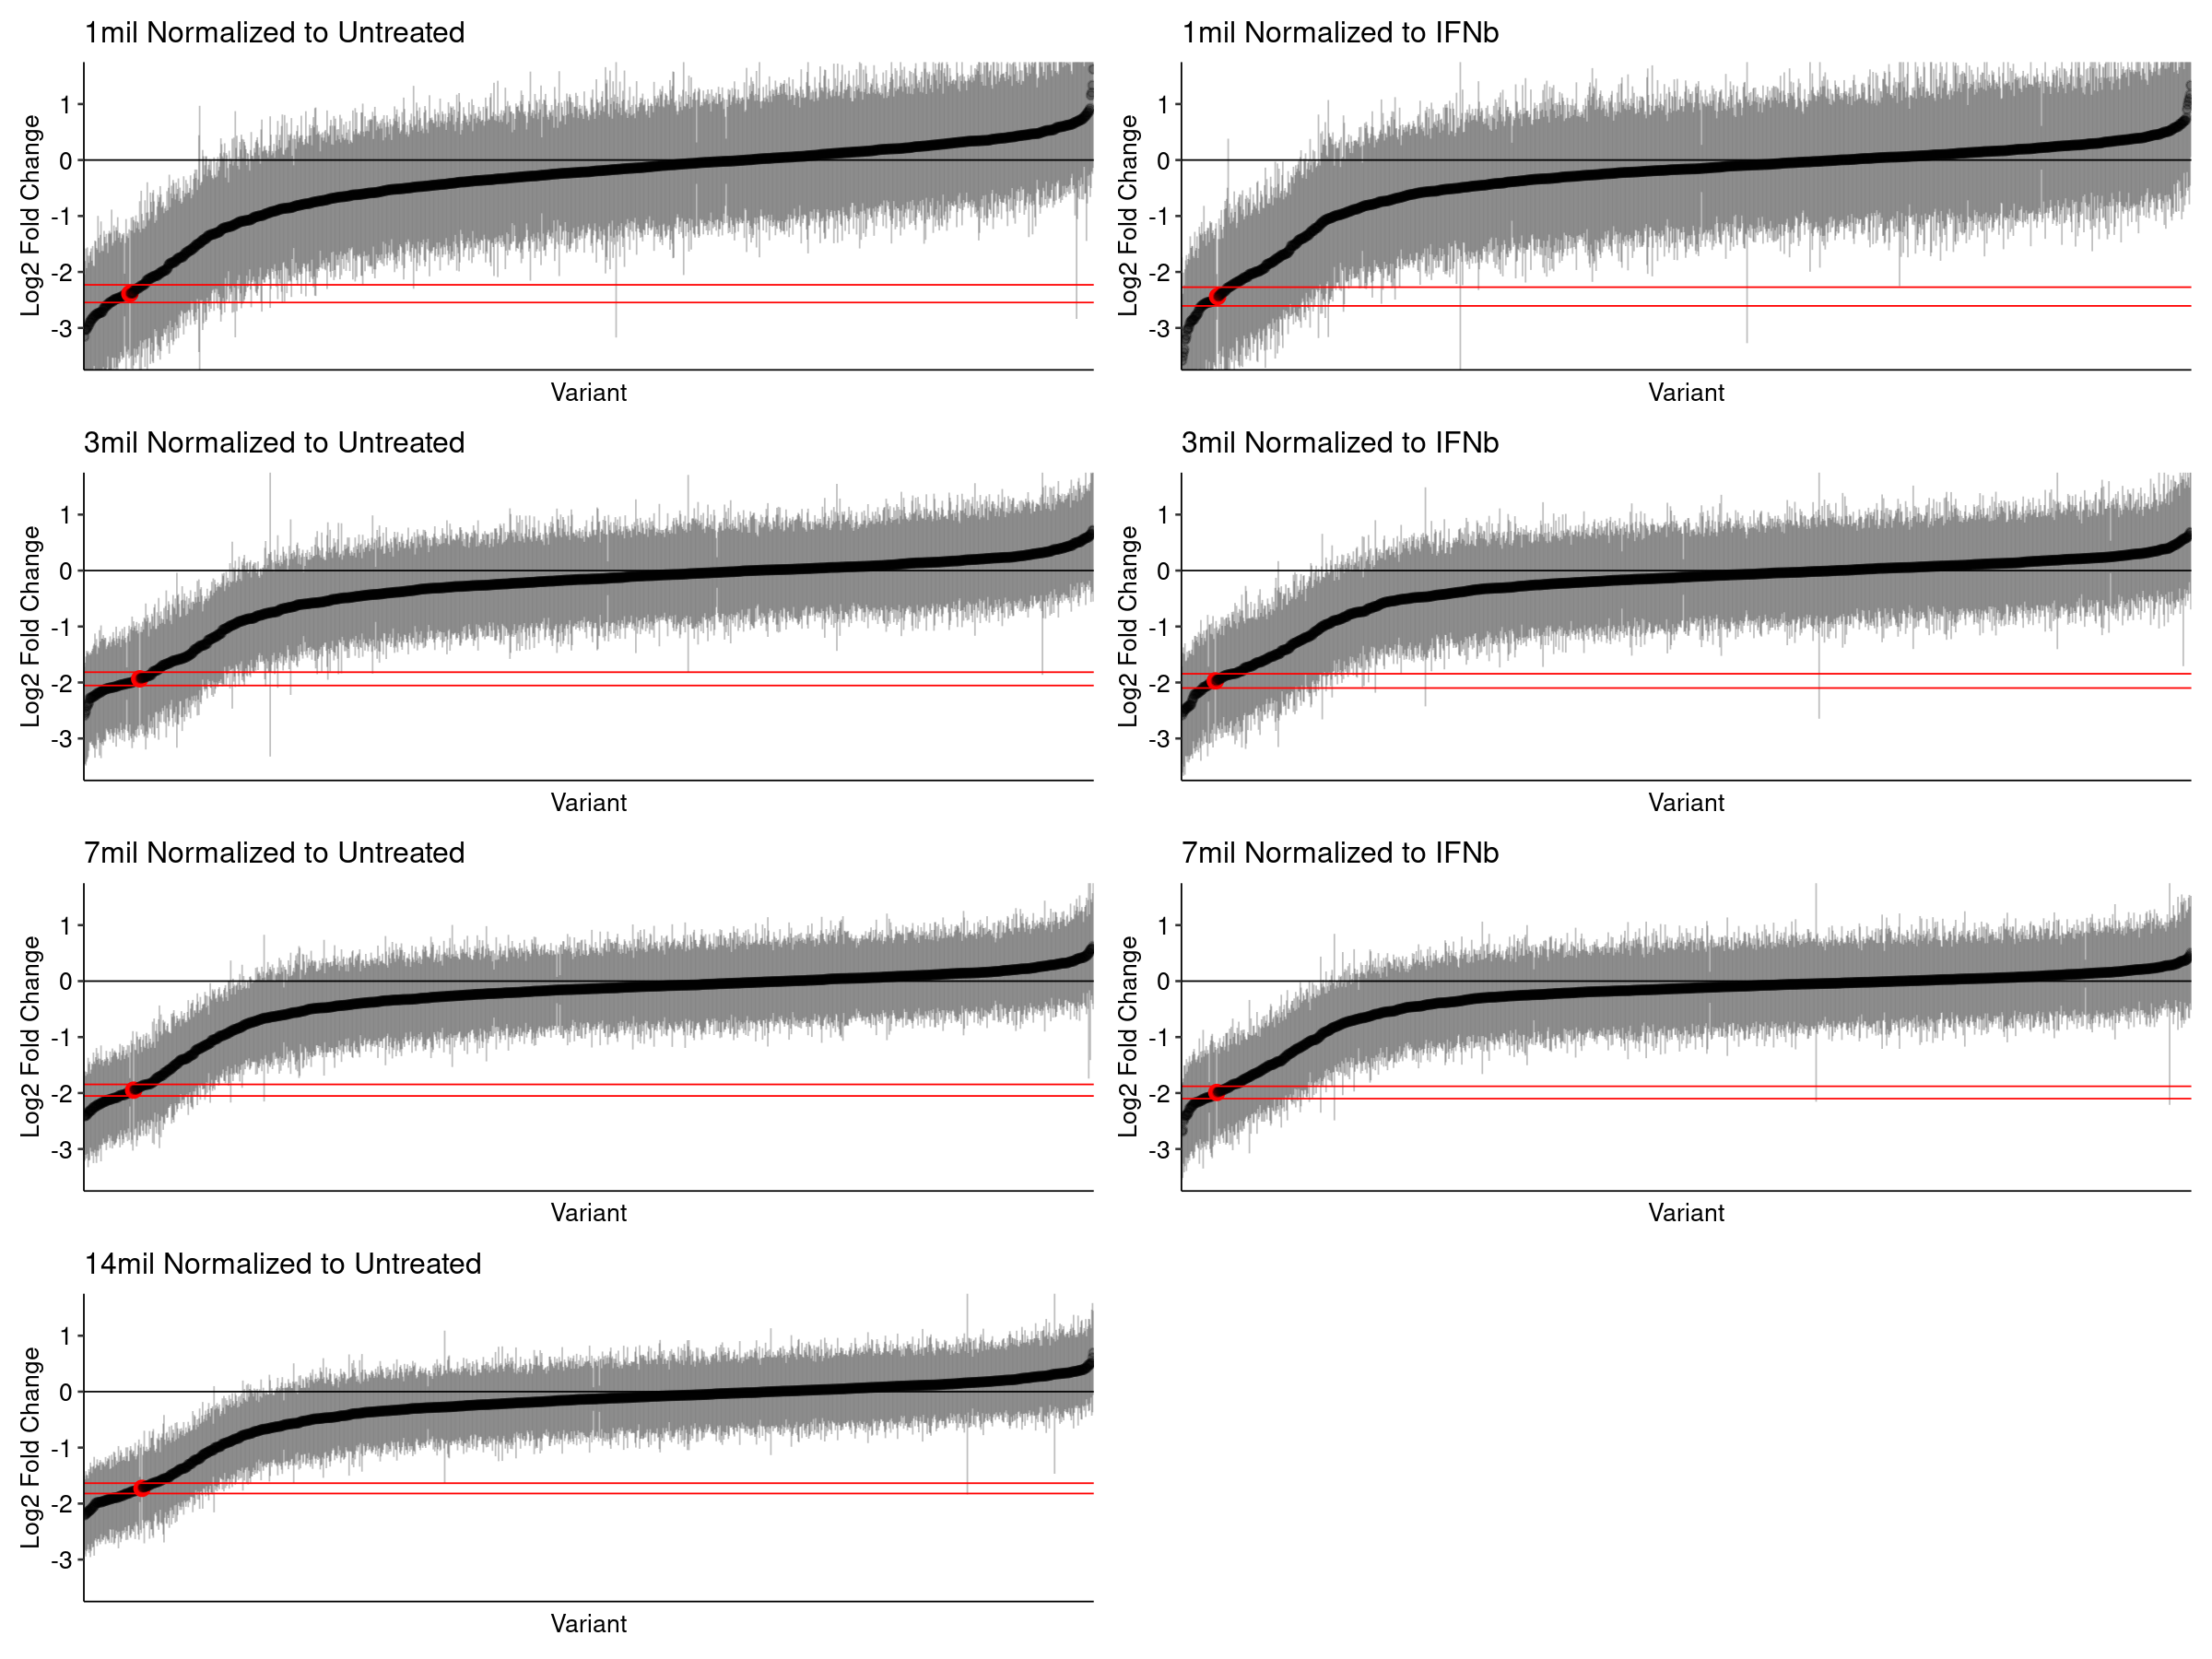

In [95]:
options(repr.plot.width = 20, repr.plot.height = 15)
wrap_plots(interval_plots[c(2,5,3,6,4,7,1)], ncol = 2)

For each comparison, we can visually observe candidate partial loss-of-function variants as those whose gray confidence intervals do not overlap either the black or red horizontal lines. These are more obvious in comparisons derived from data with larger cell counts.

#### Comparisons Across Assay Parameters

One straightforward way to see whether functional variant effects (whether LoF or partial LoF) are reproducible across assay conditions is to view a scatterplot with all pairwise comparisons. This shows that the correlation is generally very clear for all pairs, but the benefit of higher cell counts is clear. The most strongly correlated effects are observed between 14 million and 7 million cells, normalized to Untreated:

In [174]:
options(repr.plot.width = 8, repr.plot.height = 8)

idx <- as_tibble(t(combn(1:7, 2)))
idx <- expand(tibble("X" = 1:7, "Y" = 1:7), X, Y)

plot_container <- list()

for(i in 1:nrow(idx)){
    
    idx1 <- idx[[i,1]]
    idx2 <- idx[[i,2]]
    
    id1 <- paste0(sumstats_nest$density[[idx1]], " ", sumstats_nest$group[[idx1]])
    id2 <- paste0(sumstats_nest$density[[idx2]], " ", sumstats_nest$group[[idx2]])
    
    df <- bind_rows(sumstats_nest$df[[idx1]] %>% mutate(group = "X"),
                    sumstats_nest$df[[idx2]] %>% mutate(group = "Y")) %>%
        select(group, estimate, pos, mut_aa) %>%
        mutate(estimate = estimate/log(2)) %>%
        pivot_wider(names_from = group, values_from = estimate)

    if(idx1 < idx2){
        the_plot <- ggplot(df) +
            geom_point(aes(x = X, y = Y,
                           color = if_else(pos == -1, "red", "black"),
                           size = if_else(pos == -1, 5, 2),
                           alpha = if_else(pos == -1, 1, 0.6))) +
            theme_pubr(base_size = 20) +
            xlab("") + ylab("") +
            geom_abline(slope = 1, intercept = 0) +
            geom_hline(yintercept = 0) +
            geom_vline(xintercept = 0) +
            geom_vline(aes(xintercept = estimate/log(2)),
                       data = sumstats_nest$df[[idx1]] %>% filter(pos == -1),
                       color = "red") +
            geom_hline(aes(yintercept = estimate/log(2)),
                       data = sumstats_nest$df[[idx2]] %>% filter(pos == -1),
                       color = "red") +
            scale_color_identity() +
            scale_size_identity() +
            scale_alpha_identity()
    } else if (idx1 == idx2){
        the_plot <- ggplot() +
            annotate("text",
               x = 1,
               y = 1,
               size = 13,
               label = paste0(sumstats_nest$density[[idx1]], "\n",
                              gsub("to ", "to\n", sumstats_nest$group[[idx1]]))) +
            theme_void()
    } else {
        the_plot <- ggplot(df) +
            geom_blank() +
            theme_pubr() +
            theme(axis.line = element_blank())
    }

    
    plot_container[[i]] <- the_plot
    
}


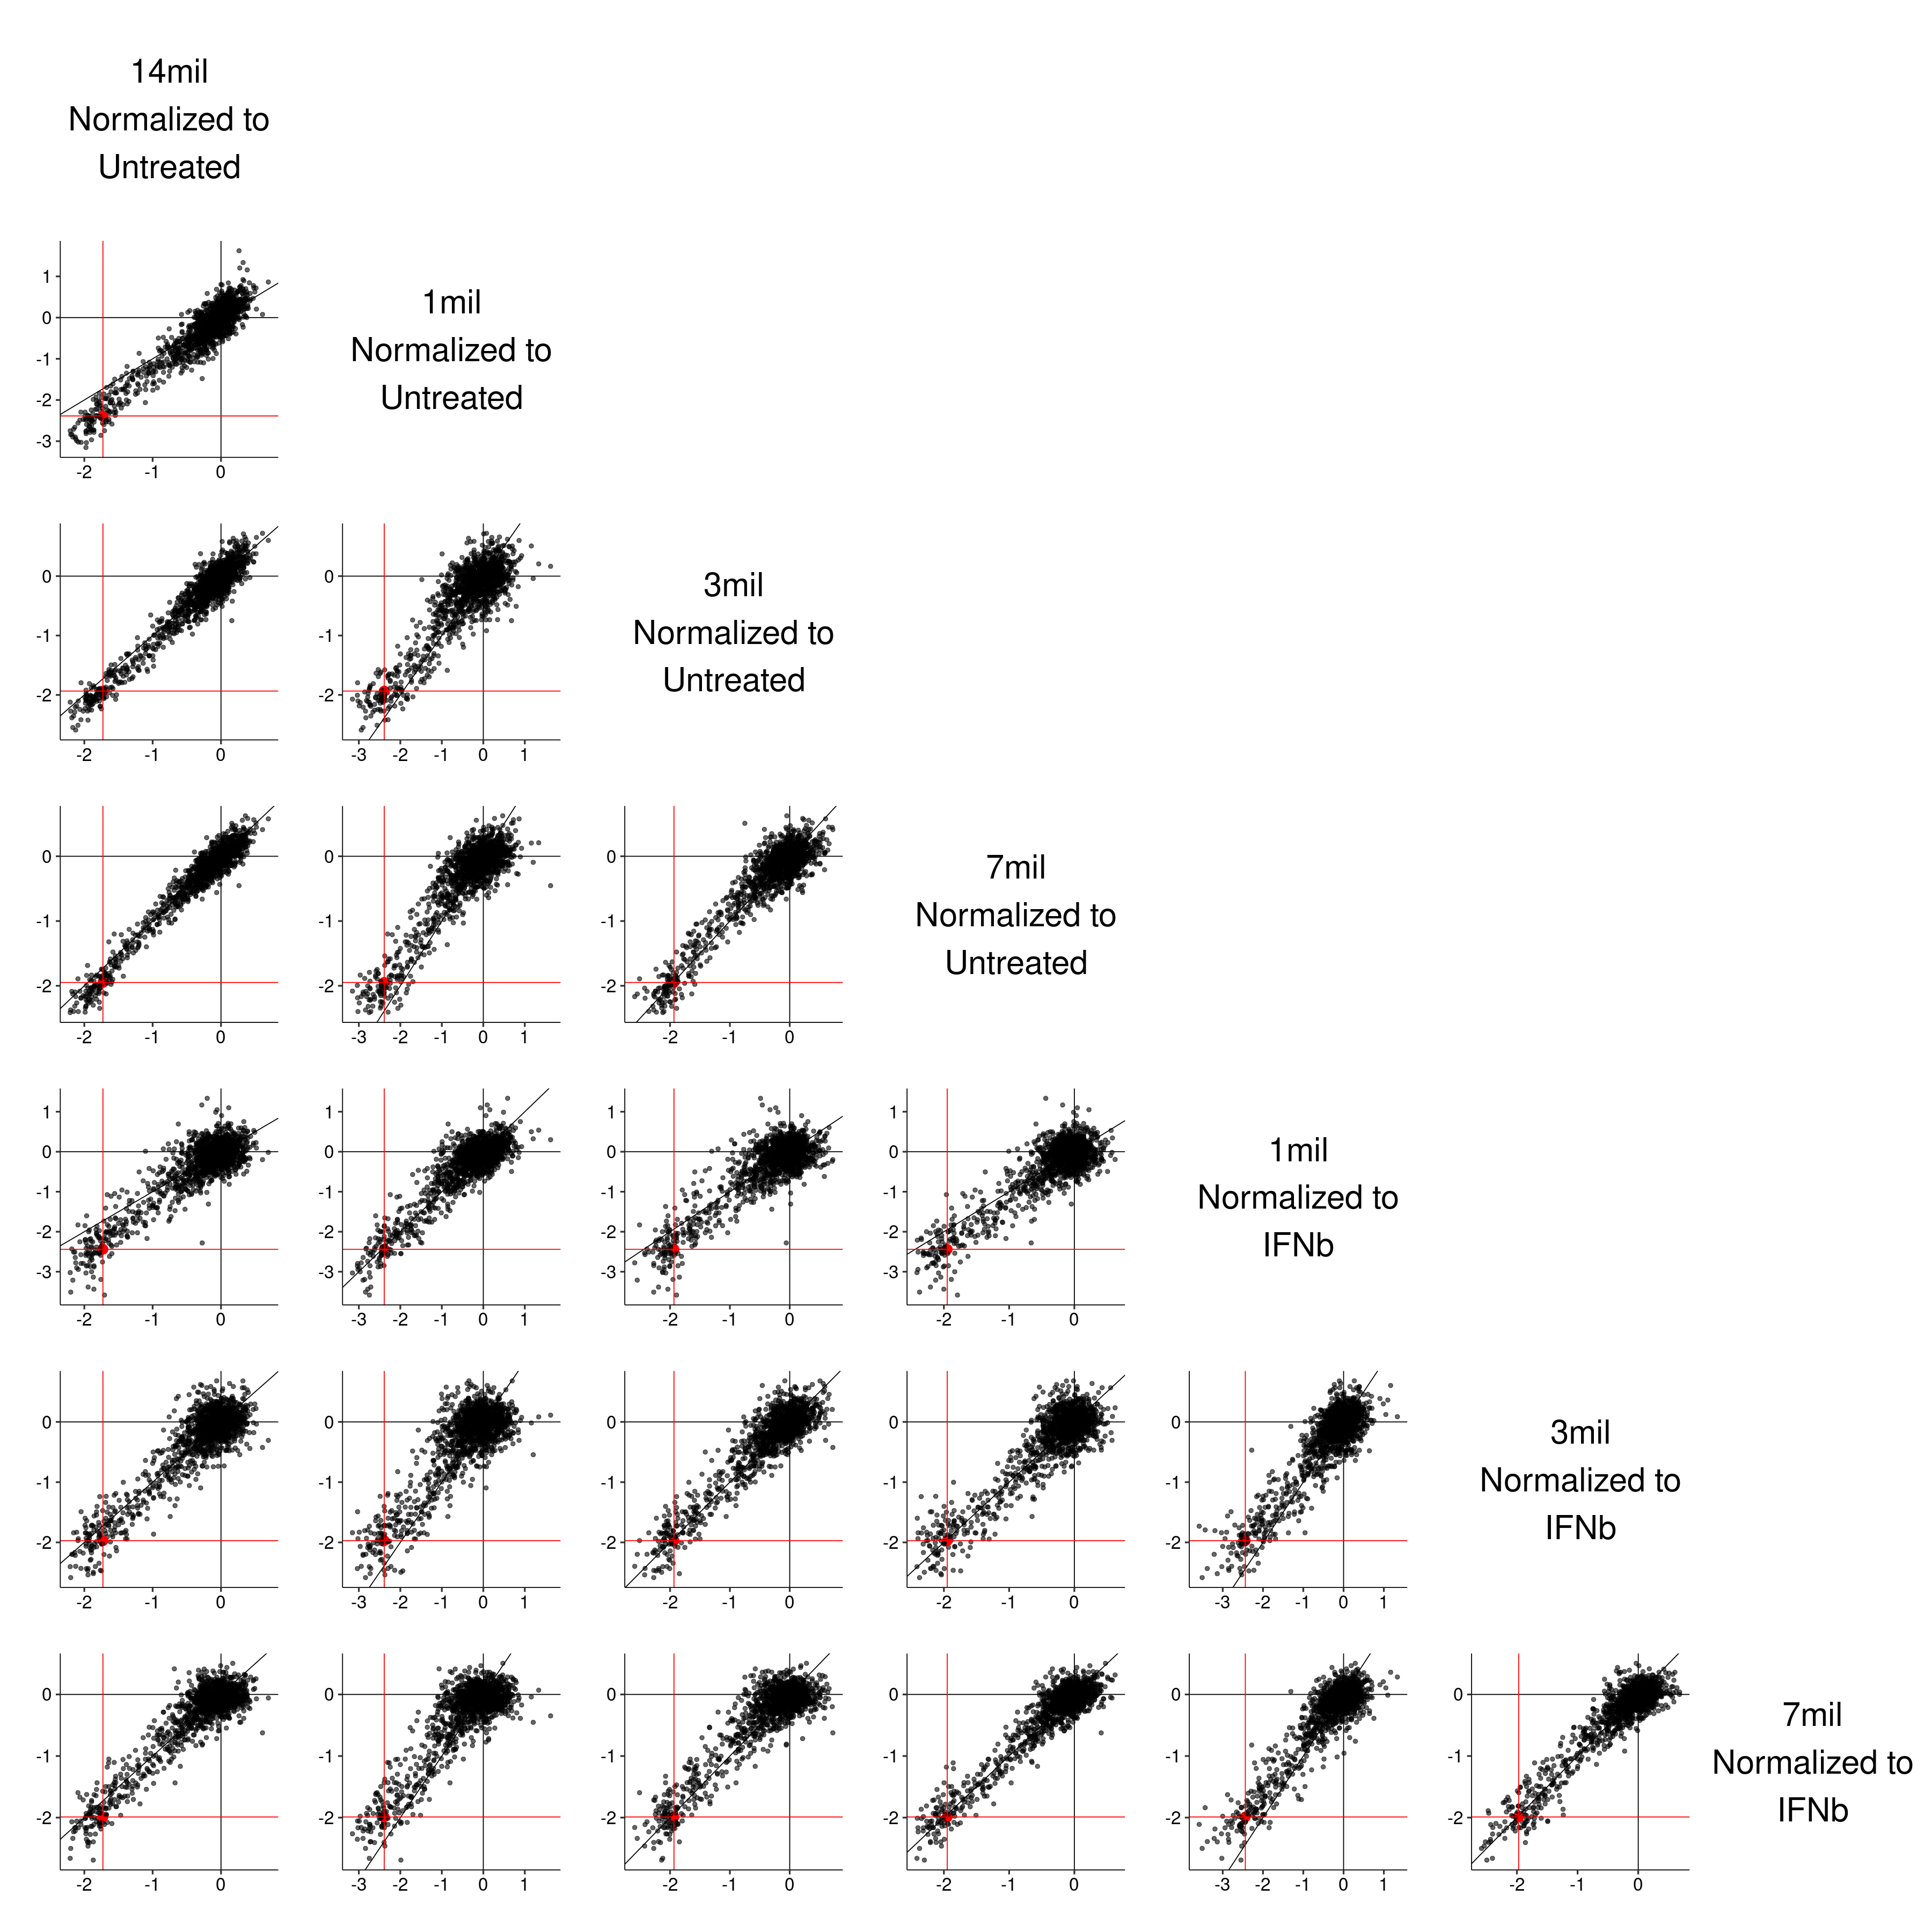

In [175]:
options(repr.plot.width = 30, repr.plot.height = 30)
wrap_plots(plot_container, ncol = 7, byrow = FALSE)

We can more compactly visualize the correlation matrix of the effect sizes (i.e. Log2 Fold Changes). This summarizes and quantifies the relationships already visible above:

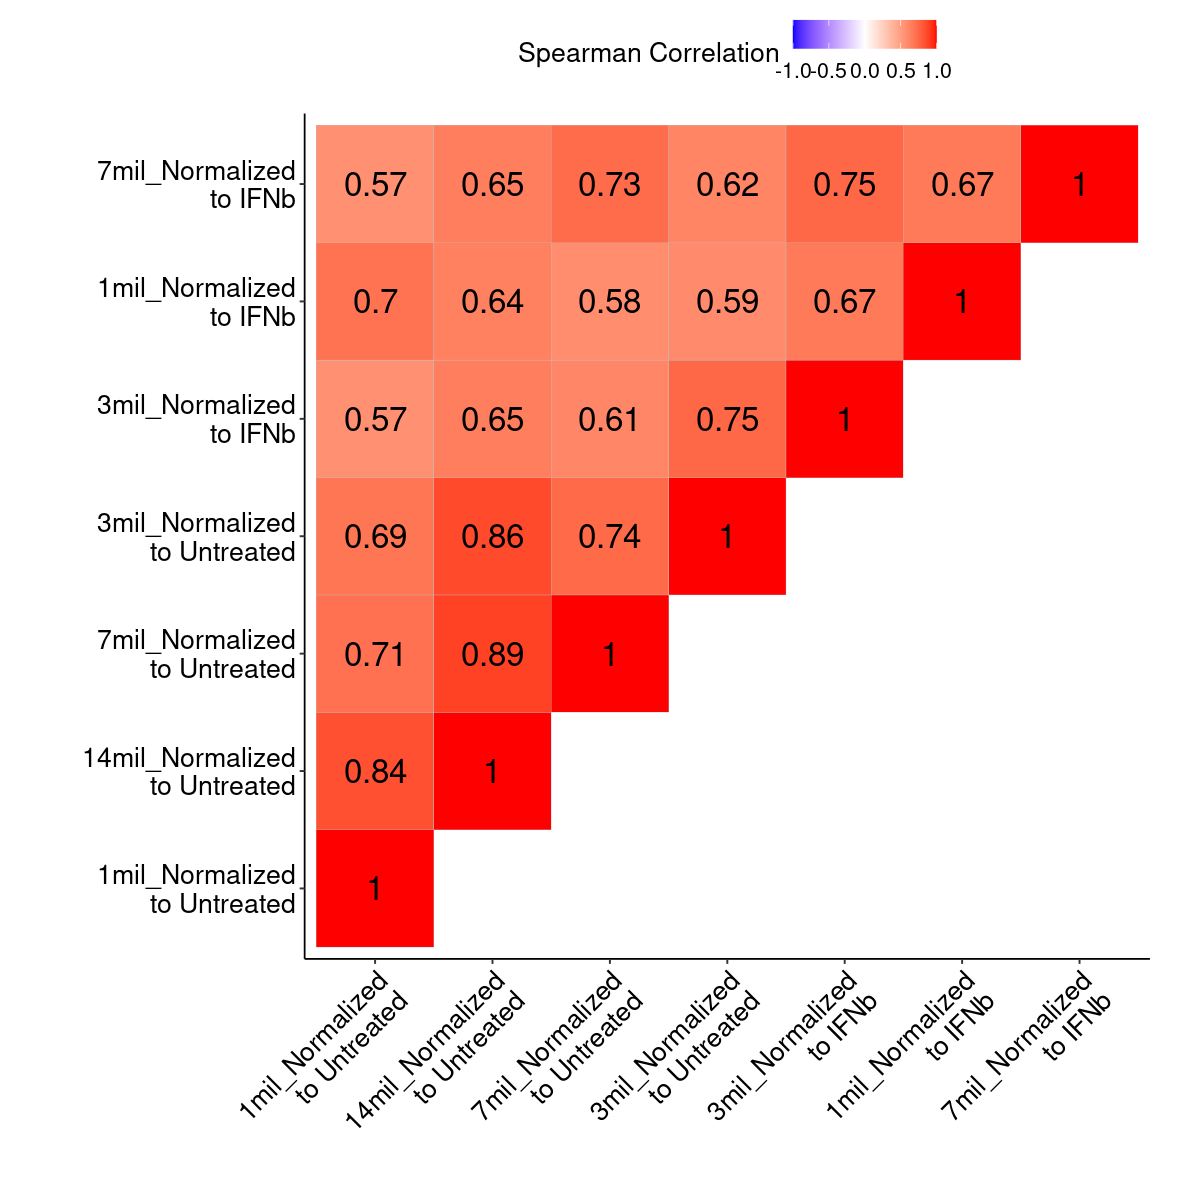

In [166]:
options(repr.plot.width = 10, repr.plot.height = 10)
cormat <- sumstats_all %>%
    ungroup() %>%
    select(density, pos, mut_aa, estimate, group) %>%
    mutate(estimate = estimate/log(2)) %>%
    pivot_wider(names_from = c(density, group), values_from = estimate) %>%
    select(-pos,-mut_aa) %>%
    as.matrix()
ggcorrplot(cor(cormat, method = "spearman"),
           legend.title = "Spearman Correlation",
           lab = T,
           lab_size = 7,
           hc.order = TRUE,
           type = "upper",
           show.diag = TRUE) +
    theme_pubr(x.text.angle = 45) + xlab("") + ylab("") +
    theme(text = element_text(size = 16))

This is all encouraging, and we know from the first section that the stop codons are all highly significant and highly negative in all comparisons. The next step is to identify partial loss-of-function variants in each condition. To do this, we consider the Z-statistic (defined as the effect size or log2 fold change divided by the standard error) of each variant relative to WT, and also relative to the combined Stop effect. The plots below show this score for the comparison to WT on the x-axis, and for the comparison to the combined Stop on the y-axis:

In [169]:
stop_effects <- sumstats_all %>% 
    filter(mut_aa == "*") %>%
    ungroup() %>%
    select(density, group, "stop_estimate" = estimate, "stop_std.error" = std.error)

sumstats_stoptest <- sumstats_all %>%
    ungroup() %>%
    select(pos, density, group, mut_aa, estimate, std.error) %>%
    filter(mut_aa != "*") %>%
    inner_join(stop_effects, by = c("density", "group")) %>%
    group_by(pos, density, group, mut_aa) %>%
    summarize(estimate = estimate - stop_estimate,
              std.error = sqrt((std.error^2)+(stop_std.error^2)),
              statistic = estimate/std.error,
              p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2)) %>%
    mutate(estimate = estimate/log(2),
           std.error = std.error/log(2))

coefs_partial_lof <- inner_join(sumstats_all %>% filter(mut_aa != "*"),
                                sumstats_stoptest,
                                by = c("pos","density","group","mut_aa")) %>%
    ungroup() %>%
    mutate(fdr.x = p.adjust(p.value.x, method = "BH"),
           fdr.y = p.adjust(p.value.y, method = "BH"))

alpha_z_compare <- ggplot(coefs_partial_lof) +
    geom_point(data = coefs_partial_lof,
               aes(x = statistic.x, y = statistic.y,
                   color = if_else(fdr.x <= 0.01 & fdr.y <= 0.01, "red", "black"))) +
    theme_pubr(base_size = 20) +
    geom_vline(xintercept = c(0)) +
    geom_hline(yintercept = c(0)) +
    xlab("Z-Statistic Mutant vs WT") + ylab("Z-Statistic Mutant vs Stop") +
    scale_color_identity() +
    facet_wrap(~density + group, nrow = 2) +
    xlim(c(-12.5, 5)) + ylim(c(-5,10))

`summarise()` has grouped output by 'pos', 'density', 'group'. You can override using the `.groups` argument.



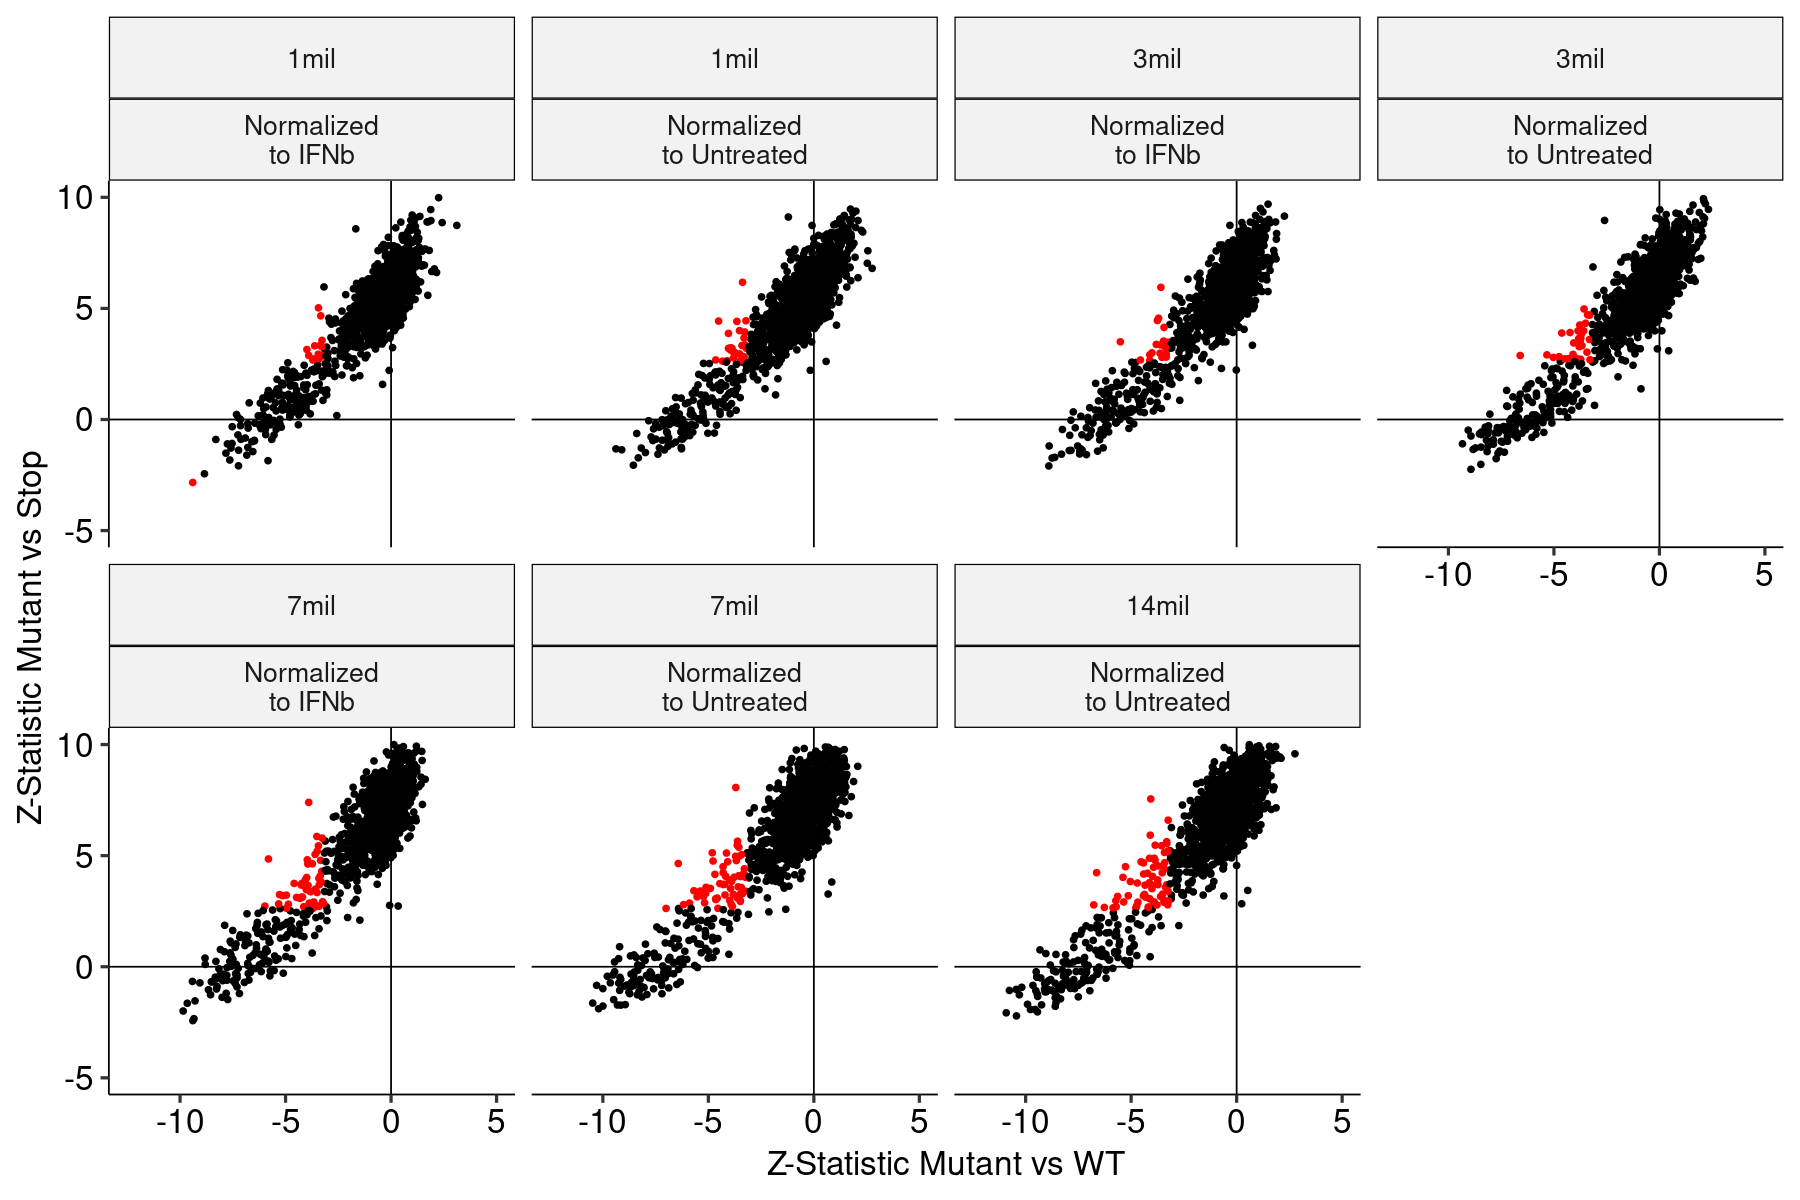

In [170]:
options(repr.plot.width = 15, repr.plot.height = 10)
alpha_z_compare

The red points indicate variants that are significant at a 1% FDR against both WT and the combined Stop effect. Visually, this is intuitive, as those are the points that have the most negative x-axis score (most negative relative to WT) while simulataneously having a high y-axis score (most positive relative to the combined Stop effect).

Using the partial loss-of-function variant sets defined above, we can create a higher-resolution comparison scatterplot between pairs of comparisons, now highlighting variants that are significantly partial LoF in one condition, the other, or both. These plots are generally too dense to show in a grid, so a directory of them (one file per pairwise comparison) is located [here](TYK2-Assay-Comparisons-pairwise-scatterplots), and two examples are shown below that describe the extremes: 14 million using untreated vs 7 million using untreated is the most reproducible, while 1 million using untreated vs 3 million using IFNb has the poorest correlation:

In [171]:
sumstats_nest_plof <- coefs_partial_lof %>%
    select(density, group, pos, mut_aa, fdr.x, fdr.y) %>%
    mutate(sig = if_else(fdr.x <= 0.01 & fdr.y <= 0.01, "sig", "nonsig")) %>%
    inner_join(sumstats_all) %>%
    mutate(estimate = estimate / log(2), std.error = std.error / log(2)) %>%
    nest(df = !c(density, group))

Joining, by = c("density", "group", "pos", "mut_aa")



In [172]:
options(repr.plot.width = 8, repr.plot.height = 8)

colors <- c("Neither" = "gray", "Both" = "red", "X-Axis Only" = "cyan", "Y-Axis Only" = "magenta")
sizes <- c("Neither" = 3, "Both" = 3, "X-Axis Only" = 3, "Y-Axis Only" = 3)
alphas <- c("Neither" = 0.3, "Both" = 1, "X-Axis Only" = 1, "Y-Axis Only" = 1)

idx <- as_tibble(t(combn(1:7, 2)))

plot_container_fancy <- list()

for(i in 1:nrow(idx)){
    
    idx1 <- idx[[i,1]]
    idx2 <- idx[[i,2]]
    
    id1 <- paste0(sumstats_nest_plof$density[[idx1]], " ", sumstats_nest_plof$group[[idx1]])
    id2 <- paste0(sumstats_nest_plof$density[[idx2]], " ", sumstats_nest_plof$group[[idx2]])
    
    df <- bind_rows(sumstats_nest_plof$df[[idx1]] %>% mutate(group = "X"),
                    sumstats_nest_plof$df[[idx2]] %>% mutate(group = "Y")) %>%
        select(group, estimate, pos, mut_aa, sig) %>%
        pivot_wider(names_from = group, values_from = c(estimate, sig)) %>%
        mutate(color = case_when(sig_X == "sig" & sig_Y == "sig" ~ "Both",
                                 sig_X == "sig" & sig_Y != "sig" ~ "X-Axis Only",
                                 sig_X != "sig" & sig_Y == "sig" ~ "Y-Axis Only",
                                 TRUE ~ "Neither")) %>%
        mutate(color = if_else(estimate_X > 0 | estimate_Y > 0, "Neither", color))

    if(idx1 < idx2){
        the_plot <- ggplot(df) +
            geom_point(aes(x = estimate_X, y = estimate_Y,
                           color = color,
                           size = color,
                           alpha = color)) +
            theme_pubr(base_size = 20) +
            xlab(id1) + ylab(id2) +
            geom_abline(slope = 1, intercept = 0) +
            geom_hline(yintercept = 0) +
            geom_vline(xintercept = 0) +
            geom_vline(aes(xintercept = estimate),
                       data = sumstats_nest_plof$df[[idx1]] %>% filter(pos == -1),
                       color = "red") +
            geom_hline(aes(yintercept = estimate),
                       data = sumstats_nest_plof$df[[idx2]] %>% filter(pos == -1),
                       color = "red") +
            scale_color_manual(values = colors) +
            scale_size_manual(values = sizes) +
            scale_alpha_manual(values = alphas) +
            theme(legend.title = element_blank())
    } 
    plot_container_fancy[[i]] <- the_plot
    
    file_name <- paste0("TYK2-Assay-Comparisons-pairwise-scatterplots/",
                        gsub(" Normalized\nto ","With", id1),
                        "vs",
                        gsub(" Normalized\nto ","With", id2),
                        ".pdf")    
    ggsave(file_name, the_plot, width = 9, height = 9)
}


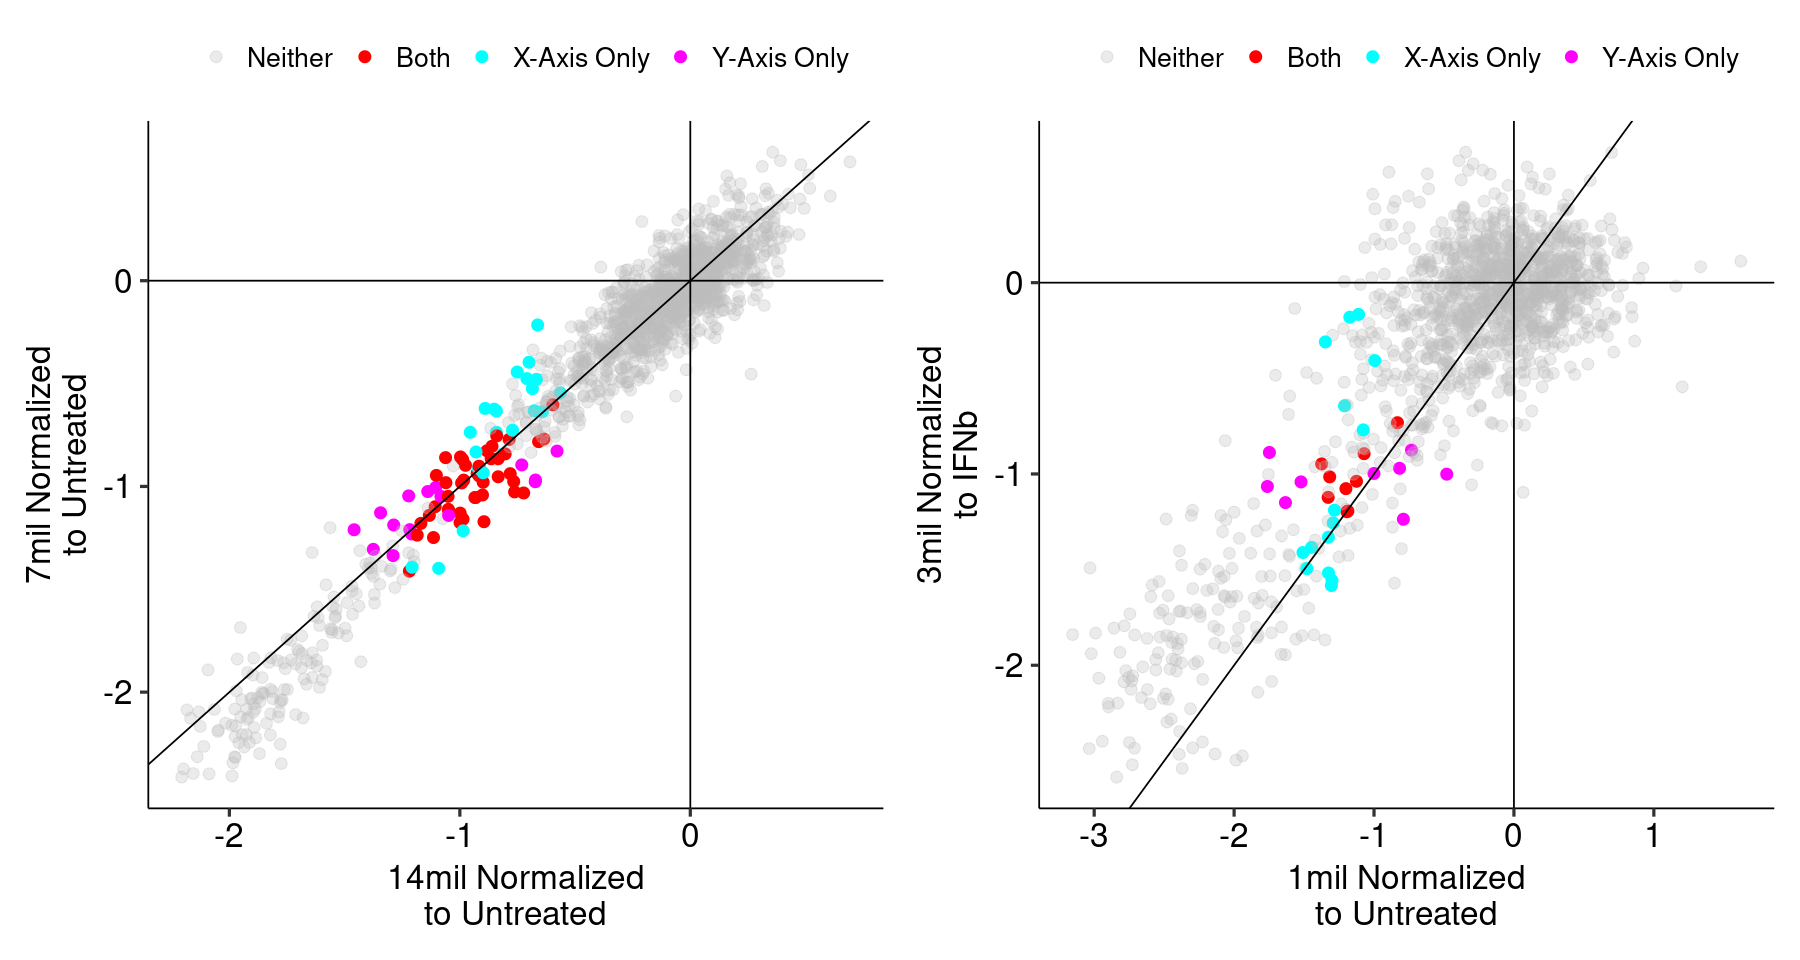

In [173]:
options(repr.plot.width = 15, repr.plot.height = 8)
plot_container_fancy[[3]] + plot_container_fancy[[10]]